In [165]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
from random import uniform, seed
from math import sqrt
import numpy as np
from Cell2D import Cell2D, draw_array
from matplotlib.colors import LinearSegmentedColormap
from scipy import signal
import seaborn as sns
from numpy import random
palette = sns.color_palette()
colors = 'white', 'red', 'blue', 'orange'
cmap = LinearSegmentedColormap.from_list('cmap', colors)

In [191]:
seed(10)
class grid_houses(Cell2D):
    """Represents a grid of Schelling agents."""
    
    def __init__(self, n, prob_empty,kernel):
        """Initializes the attributes.
        
        n: number of rows
        p: happiness threshold on the fraction of similar neighbors
        """
        super().__init__(n)
        self.prob_emp = prob_empty    # probability of empty cells occurring
        self.prob_house = (1 - self.prob_emp)
        self.kernel = kernel
        # 0 is empty, 1 is red, 2 is blue
        choices = np.array([0, 1], dtype = np.int8)
        probs = [self.prob_emp, self.prob_house]
        # use the numpy routine choice to select the different cells with probability

        self.values = np.random.rand(n, n) # uniformly distribute the values
        self.array = np.random.choice(choices, (n, n), probs)


    def average_neighbors(self):
        out = signal.convolve2d(self.values, self.kernel, boundary='fill', mode='same')/kernel.sum()
        return(out)

    def draw_values(self):
        return draw_array(self.values)

    def update_values(self, grid_agents):
        self.array = self.average_neighbors() + grid_agents.affluences

class grid_agents(Cell2D):
    """Represents a grid of Schelling agents."""

    def __init__(self, n, prob_empty,grid_houses):
        """Initializes the attributes.
        
        n: number of rows
        p: happiness threshold on the fraction of similar neighbors
        """
        super().__init__(n)
        self.affluences = np.random.rand(n,n)
        self.prob_emp = prob_empty    # probability of empty cells occurring
        self.prob_rich = (1 - self.prob_emp)/3
        self.prob_middle= (1 - self.prob_emp)/3
        self.prob_poor = (1 - self.prob_emp)/3
        self.size = n
        # 0 is empty, 1 is red, 2 is blue
        choices = np.array([0, 1,2,3], dtype = np.int8)
        
        probs = [self.prob_emp, self.prob_rich,self.prob_middle,self.prob_poor]
        # use the numpy routine choice to select the different cells with probability
        self.array = np.random.choice(choices, (n, n), probs)
        self.array = np.multiply(self.array,grid_houses.array)

    def draw(self):
        """Draws the cells."""
        return draw_array(self.array, cmap=cmap, vmax=3)
    def draw_affluences(self):
        return draw_array(self.affluences)

    def swap_people(self):
        i1 = random.randint(0,self.size)
        j1 = random.randint(0,self.size)
        i2 = random.randint(0,self.size)
        j2 = random.randint(0,self.size)
        a1 = self.array[i1][j1]
        b1 = self.affluences[i1][j1]
        self.array[i1][j1] = self.array[i2][j2]
        self.affluences[i1][j1] = self.affluences[i2][j2]
        self.array[i2][j2] = a1
        self.affluences[i2][j2] = b1



In [187]:
# kernel used for counting a cell's neighbours
kernel = np.array([[1,1,1, 1, 1],
                   [1,1,1, 1, 1],
                   [1,1, 0, 1,1],
                   [1,1,1, 1, 1],
                   [1,1,1, 1, 1]], dtype=np.int8)

In [188]:
grid_houses1 = grid_houses(10,0.1, kernel)

grid_agents1 = grid_agents(10, 0.1, grid_houses1)

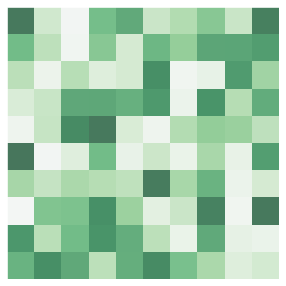

In [189]:
grid_houses1.draw_values()

In [192]:
for i in range(10):
    grid_agents1.swap_people()
    grid_houses.update_values(grid_houses1,grid_agents1)

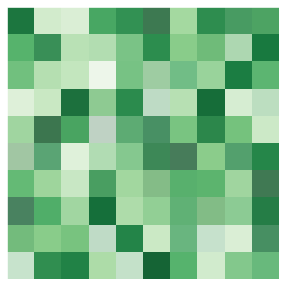

In [193]:
grid_houses1.draw_values()
grid_agents1.draw_affluences()

In [ ]:
grid_houses.draw_values()
grid_agents.draw_affluences()